<IPython.core.display.Javascript object>


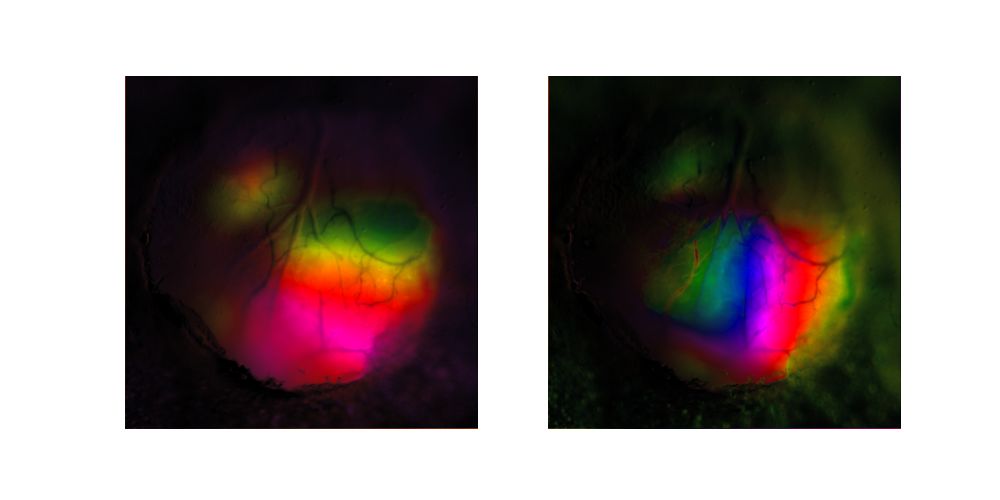

In [81]:
# this computes the average and fft on in SVD space which is insane fast

%matplotlib notebook
from wfield import *
from scipy.io import loadmat
from numpy.fft import fft
import numpy as np
import math
import cv2
from tifffile import imsave
evn = loadmat('xx0_003_003.mj2_events',squeeze_me=True)['ttl_events']
evt = evn[:,2].astype(int)*255 + evn[:,1]

U = np.load('U.npy')
SVT = np.load('SVT.npy')
avg = []
raw = []
for e,i in enumerate(evt):
    avg.append(np.mean(SVT[:,np.arange(i,i+10*10*10)].reshape([-1,10,100]),axis=1))
    raw.append(SVT[:,np.arange(i,i+10*10*10)])
    imsave('avg_stim_{0}.tif'.format(e),reconstruct(U,avg[-1]))
    
#from scipy.ndimage.filters import gaussian_filter,median_filter
#mov = runpar(median_filter,U.transpose(2,0,1) ,size=5)
#U2 = np.stack(mov).transpose(1,2,0).astype(np.float32)
U2 = U.copy()

fig = plt.figure(figsize=[10,5])
fig.add_subplot(1,2,1)

component = 10 # nrepeats
a = reconstruct(U2,fft(raw[0].T, axis = 0)[component])
b = reconstruct(U2,fft(raw[1].T, axis = 0)[component])
phase  = -1. * (np.angle(a)-np.angle(b)) % (2*np.pi)
mag = (np.abs(a+b)*2.)

plt.imshow(im_fftphase_hsv([mag,phase]))
plt.axis('off')

fig.add_subplot(1,2,2)

U2 = U.copy()
a = reconstruct(U2,fft(raw[2].T, axis = 0)[component])
b = reconstruct(U2,fft(raw[3].T, axis = 0)[component])
phase1  = -1. * (np.angle(a)-np.angle(b)) % (2*np.pi)
mag = (np.abs(a+b)*2.)

plt.imshow(im_fftphase_hsv([mag,phase1]))
plt.axis('off')
plt.savefig('az_el_unfiltered.pdf')

<IPython.core.display.Javascript object>


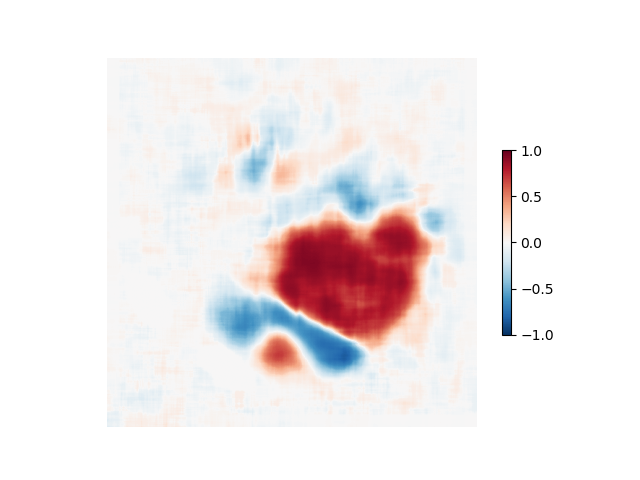

In [74]:
from scipy.ndimage.filters import gaussian_filter
plt.figure()
plt.imshow(median_filter(visual_sign_map(phase, phase1),33),cmap='RdBu_r',clim = [-1,1])
plt.colorbar(shrink=0.5)
plt.axis('off')
plt.savefig('phasemap.pdf')

<IPython.core.display.Javascript object>


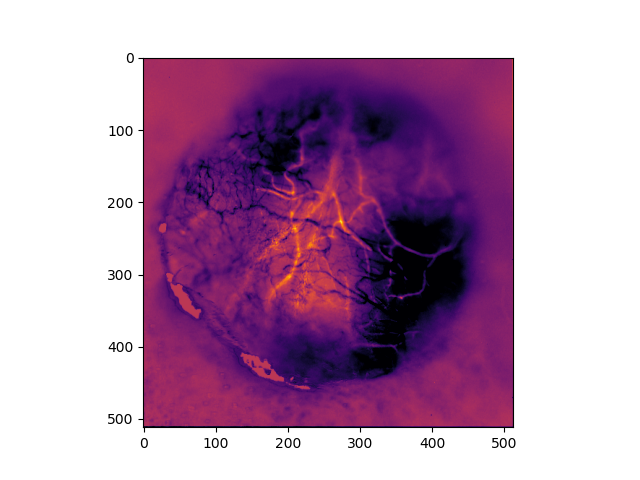

{'fig': <Figure size 640x480 with 1 Axes>,
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd439a1c9d0>,
 'im': <matplotlib.image.AxesImage at 0x7fd438d4ead0>,
 'update': <function wfield.viz.nb_play_movie.<locals>.updateImage(change)>}

In [73]:
%matplotlib notebook
nb_play_movie(reconstruct(U2,avg[3]),cmap='inferno',clim=[-0.05,0.05])

In [76]:
#Save the original image
dat = VideoStack('.')
imsave('orig_im.tif',dat[0])

In [1]:
from wfield import *

def fft_movie(movie, component = 1,output_raw = False):
    '''
    Computes the fft of a movie and returns the magnitude and phase 
    '''
    movief = fft(movie, axis = 0)
    if output_raw:
        return movief[component]
    phase  = -1. * np.angle(movief[component]) % (2*np.pi)
    mag = (np.abs(movief[component])*2.)/len(movie)
    return mag,phase

def fft_get_phase(movief):
    return -1. * np.angle(movief) % (2*np.pi)

def phasemap_to_visual_degrees(phasemap,startdeg,stopdeg):
    '''
    Normalizes the phasemap to visual angles
    Joao Couto 2019
    '''
    res = phasemap.copy() - np.nanmin(phasemap)
    res /= np.nanmax(res)
    res *= np.abs(np.diff([startdeg,stopdeg]))
    res += startdeg
    return res

def visual_sign_map(phasemap1, phasemap2):
    '''
    Computes the visual sign map from azimuth and elevation phase maps
    This is adapted from the Allen retinotopy code
    '''
    gradmap1 = np.gradient(phasemap1)
    gradmap2 = np.gradient(phasemap2)
    import scipy.ndimage as ni
    graddir1 = np.zeros(np.shape(gradmap1[0]))
    graddir2 = np.zeros(np.shape(gradmap2[0]))
    for i in range(phasemap1.shape[0]):
        for j in range(phasemap2.shape[1]):
            graddir1[i, j] = math.atan2(gradmap1[1][i, j], gradmap1[0][i, j])
            graddir2[i, j] = math.atan2(gradmap2[1][i, j], gradmap2[0][i, j])
    vdiff = np.multiply(np.exp(1j * graddir1), np.exp(-1j * graddir2))
    areamap = np.sin(np.angle(vdiff))
    return areamap

def im_fftphase_hsv(mov,component = 1,blur = 0,vperc=98,sperc=90,return_hsv=False):
    '''
    im_fftphase_hsv(mov,blur = 0,vperc=99,sperc=90)
    
    Creates a color image colorcoding the frame with fourier phase for each pixel 
    
        mov can be a 3d array or a list with the [magnitude, phase]
'''
    if not blur == 0:
        mov = runpar(im_gaussian,mov,sigma=blur)
    if not type(mov) is list:
        mag,H = fft_movie(mov,component = component)
    else:
        mag,H = mov
    H = H/(2*np.pi)
    V = mag.copy()
    V /= np.percentile(mag,vperc)
    S = mag**0.3
    S /= np.percentile(S,sperc)
    if return_hsv:
        return np.stack([H,S,V],axis=2).astype(np.float32)
    # Normalization for opencv ranges 0-255 for uint8
    hsvimg = np.clip(np.stack([H,S,V],axis=2).astype(np.float32),0,1)
    hsvimg *= 255
    return cv2.cvtColor(hsvimg.astype(np.uint8), cv2.COLOR_HSV2RGB_FULL)


def im_argmax_hsv(mov,blur = 0,vperc=98,sperc=90,return_hsv=False):
    '''
    im_argmax_hsv(mov,blur = 0,vperc=99,sperc=90)
    
    Creates a color image colorcoding the frame with largest amplitude for each pixel 
    '''
    if not blur == 0:
        mov = runpar(im_gaussian,mov,sigma=blur)
    H = np.argmax(mov,axis = 0)/np.float32(len(mov))
    maxim = np.max(mov,axis=0)
    meanim = np.mean(mov,axis=0)
    V = maxim.copy()
    V /= np.percentile(maxim,vperc)
    S = maxim-meanim
    S /= np.percentile(S,sperc)
    if return_hsv:
        return np.stack([H,S,V],axis=2).astype(np.float32)
    # Normalization for opencv ranges 0-255 for uint8
    hsvimg = np.clip(np.stack([H,S,V],axis=2).astype(np.float32),0,1)
    hsvimg *= 255
    return cv2.cvtColor(hsvimg.astype(np.uint8), cv2.COLOR_HSV2RGB_FULL)

def im_combineproj_hsv(stacks,
                       proj_funct = lambda x: np.nanstd(x,axis = 0),
                       vperc=98, sperc=98,
                       return_hsv=False):
    '''
    im_combineproj_hsv (stacks,
                        proj_funct=lambda x: np.std(x,axis = 0),
                        vperc=99, sperc=98)
    
    Creates a color image colorcoding the projections in space 
    '''
    proj = np.stack([proj_funct(x) for x in stacks])
    V,H = fft_movie(proj)
    H = H/(2*np.pi)
    S = V.copy()
    S = S
    S /= np.percentile(S,sperc)
    V /= np.percentile(V,vperc)
    if return_hsv:
        return np.stack([H,S,V],axis=2).astype(np.float32)
    # Normalization for opencv ranges 0-255 for uint8 
    hsvimg = np.clip(np.stack([H,S,V],axis=2),0,1)
    hsvimg[:,:,1:] *= 255
    hsvimg[:,:,0] *= 180
    return cv2.cvtColor(hsvimg.astype(np.uint8),
                        cv2.COLOR_HSV2RGB)                   



In [1]:

dat = load_stack('.')


In [ ]:
plt.figure()
nb_play_movie(tmp)

In [22]:

fnames = natsorted(glob('*.mj2'))

dims = []
dtype = None
for fname in fnames:
    with FFmpegReader(fname) as f:
        dims.append(f.getShape())
        if f.pix_fmt == 'gray16le':
            dtype = np.uint16 
        else:
            dtype = np.uint8
        pix_fmt = f.pix_fmt
inputdict = {'-pix_fmt':pix_fmt}
outputdict = inputdict
with FFmpegReader(fnames[0],inputdict = {'-ss':'00:01:00.10'},
                  outputdict=outputdict) as nf:
    for i,frame in enumerate(nf):
        a = frame
        break
with FFmpegReader(fnames[0],
                  outputdict=outputdict) as nf:
    for i,frame in enumerate(nf):
        b = frame
        break

# basenames = [os.path.basename(f) for f in fnames]

# frames = mmap_dat(fnames[99])

In [26]:
1/(0.1/1000)

10000.0

In [13]:
test = FFmpegReader(fname,inputdict=inputdict,outputdict=outputdict)
for i,frame in tqdm(enumerate(test)):
    frame

0it [00:02, ?it/s]


In [1]:
from wfield.io import _imager_parse_file
import time
t = time.time()
ch1,ch2,info = _imager_parse_file('d:data/dataset2-phasemap/Frames_2_640_540_uint16_0001.mj2')
time.time()-t

21.885929822921753

In [7]:
from wfield import *
im = ImagerStack('d:data/dataset2-phasemap/')
# create a file to store the motion correction results
motioncorrected_fname = 'd:/data/dataset2-phasemap/wfield/motion_corrected_{0}_{1}_{2}_{3}.bin'.format(
    *im.shape[1:],im.dtype)
out = np.memmap(motioncorrected_fname,
                dtype = im.dtype,
                mode = 'w+',
                shape=im.shape)
motion_correct(im,out=out)
out.flush()
del out


Parsing files to access the stack size:   5%|▌         | 3/60 [01:04<20:19, 21.39s/it]

ValueError: invalid literal for int() with base 10: 'N/A\r'

In [36]:
i = 1
stimonsets = np.zeros((len(im.frames_offset)-1),dtype=int)
for i in range(len(stimonsets)):
    stimonsets[i] = np.where(im.extrainfo[i]['ch1'][-1*len(im.index_ch1[i]):]<im.extrainfo[i]['ch3_onset'][0])[-1][-1]
stimonsets = im.frames_offset[:-1]+stimonsets
np.save(pjoin('d:data/DemoRec_new/','stim_onsets.npy'),stimonsets)
#[im.extrainfo[9]['ch2'],im.index_ch2[9]]


'C:\\Users\\Anne\\lib\\wfield\\notebooks'

In [24]:
([im.extrainfo[i]['ch1'][-1*len(im.index_ch1[i]):]])

[array([ 261,  294,  327,  361,  394,  427,  461,  494,  527,  561,  594,
         627,  661,  694,  727,  761,  794,  827,  861,  894,  927,  961,
         994, 1027, 1061, 1094, 1127, 1161, 1194, 1227, 1261, 1294, 1327,
        1361, 1394, 1428, 1461, 1494, 1528, 1561, 1594, 1628, 1661, 1694,
        1728, 1761, 1794, 1828, 1861, 1894, 1928, 1961, 1994, 2028, 2061,
        2094, 2128, 2161, 2194, 2228, 2261, 2294, 2328, 2361, 2394, 2428,
        2461, 2494, 2528, 2561, 2594, 2628, 2661, 2694, 2728, 2761, 2794,
        2828, 2861, 2894, 2928, 2961, 2995, 3028, 3061, 3095, 3128, 3161,
        3195, 3228, 3261, 3295, 3328, 3361, 3395, 3428, 3461, 3495, 3528,
        3561, 3595, 3628, 3661, 3695, 3728, 3761, 3795, 3828, 3861, 3895,
        3928, 3961, 3995, 4028, 4061, 4095, 4128, 4161, 4195, 4228, 4261,
        4295, 4328, 4361, 4395, 4428, 4461, 4495, 4528, 4562, 4595, 4628,
        4662, 4695, 4728, 4762, 4795, 4828, 4862, 4895, 4928, 4962, 4995,
        5028, 5062, 5095, 5128, 5162, 

In [7]:
nframes,nchan,h,w = im.shape
chunks = chunk_indices(im.nframes,512)
chunks

[[0, 512],
 [512, 1024],
 [1024, 1536],
 [1536, 2048],
 [2048, 2560],
 [2560, 3072],
 [3072, 3584],
 [3584, 4096],
 [4096, 4608],
 [4608, 5120],
 [5120, 5632],
 [5632, 6144],
 [6144, 6656],
 [6656, 7168],
 [7168, 7680],
 [7680, 8192],
 [8192, 8704],
 [8704, 9216],
 [9216, 9728],
 [9728, 10240],
 [10240, 10752],
 [10752, 11264],
 [11264, 11776],
 [11776, 12288],
 [12288, 12800],
 [12800, 13312],
 [13312, 13824],
 [13824, 14336],
 [14336, 14848],
 [14848, 15360],
 [15360, 15872],
 [15872, 16384],
 [16384, 16896],
 [16896, 17408],
 [17408, 17920],
 [17920, 18432],
 [18432, 18944],
 [18944, 19456],
 [19456, 19968],
 [19968, 20480],
 [20480, 20992],
 [20992, 21504],
 [21504, 22016],
 [22016, 22528],
 [22528, 23040],
 [23040, 23552],
 [23552, 24064],
 [24064, 24576],
 [24576, 25088],
 [25088, 25600],
 [25600, 26112],
 [26112, 26624],
 [26624, 27136],
 [27136, 27648],
 [27648, 28160],
 [28160, 28672],
 [28672, 29184],
 [29184, 29696],
 [29696, 30208],
 [30208, 30720],
 [30720, 31232],
 [31232

In [12]:
tmp=im[chunks[10][0]:chunks[10][1]]

<IPython.core.display.Javascript object>


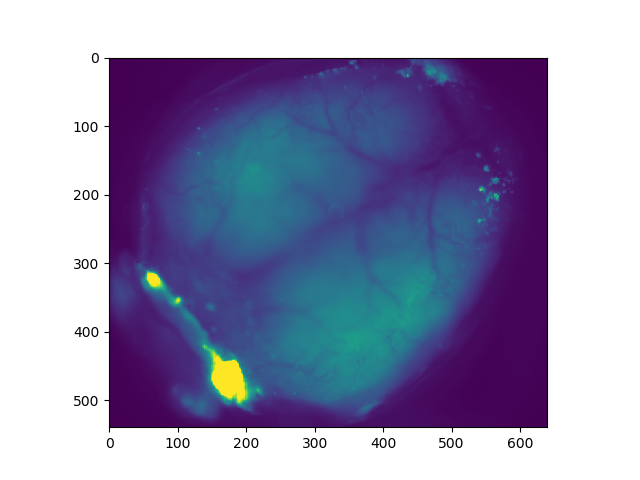

{'fig': <Figure size 640x480 with 1 Axes>,
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x26686104148>,
 'im': <matplotlib.image.AxesImage at 0x2668611b608>,
 'update': <function wfield.viz.nb_play_movie.<locals>.updateImage(change)>}

In [13]:
# plt.imshow(im.current_stack)
%matplotlib notebook
nb_play_movie(tmp[:,0])

In [15]:
im.current_fileidx

29

-0.009994983673095703


Motion correction: 100%|██████████| 96/96 [35:21<00:00, 22.10s/it]


((array([[-0.0650674 ,  0.02938396],
         [-0.07188421,  0.03500465],
         [-0.0417087 ,  0.04573603],
         ...,
         [ 0.16216244,  0.01101837],
         [ 0.14892977,  0.0012058 ],
         [ 0.1661587 , -0.00931031]], dtype=float32),
  array([[-0.10765505, -0.18709362],
         [-0.1096476 , -0.16675735],
         [-0.10614093, -0.18012562],
         ...,
         [-1.0961893 , -0.9883798 ],
         [-1.064737  , -1.0010457 ],
         [-1.0851187 , -0.9913155 ]], dtype=float32)),
 array([[ 0.02084134,  0.01783858],
        [ 0.02101292,  0.01741211],
        [ 0.02220128,  0.01955499],
        ...,
        [-0.09474912, -0.08598787],
        [-0.09402221, -0.08566966],
        [-0.09479563, -0.08537325]], dtype=float32))

<IPython.core.display.Javascript object>


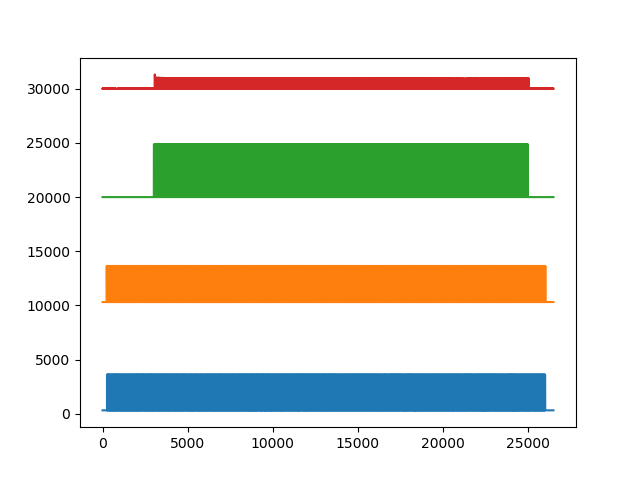

In [6]:
%matplotlib notebook
dat,header = read_imager_analog(pjoin('d:data/dataset2-phasemap/','Analog_{0}.dat'.format(10)))
plt.figure()
plt.plot(dat[0],dat[1:].T+10000*np.arange(len(dat)-1))

In [47]:
np.diff(np.sort(np.hstack([im.extrainfo[0]['ch1'],im.extrainfo[0]['ch2']])))

array([16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16,
       17, 16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16, 17, 16, 17, 17, 17,
       16, 17, 16, 17, 17, 17, 16, 17, 16, 17, 17, 17, 16, 17, 16, 17, 17,
       17, 16, 17, 16, 17, 17, 17, 16, 17, 16, 17, 17, 17, 16, 17, 16, 17,
       17, 17, 16, 17, 16, 17, 17, 17, 16, 17, 16, 18, 16, 17, 16, 17, 16,
       18, 16, 17, 16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16, 17, 16, 17,
       16, 18, 16, 17, 16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16, 17, 16,
       17, 16, 18, 16, 17, 16, 17, 17, 17, 16, 17, 16, 17, 17, 17, 16, 17,
       16, 17, 17, 17, 16, 17, 16, 17, 17, 17, 16, 17, 16, 17, 17, 17, 16,
       17, 16, 17, 17, 17, 16, 17, 16, 17, 17, 17, 16, 17, 16, 18, 16, 17,
       16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16,
       17, 16, 17, 16, 18, 16, 17, 16, 17, 16, 18, 16, 17, 16, 17, 16, 18,
       16, 17, 16, 17, 16, 18, 16, 17, 16, 17, 17, 17, 16, 17, 16, 17, 17,
       17, 16, 17, 16, 17

<IPython.core.display.Javascript object>


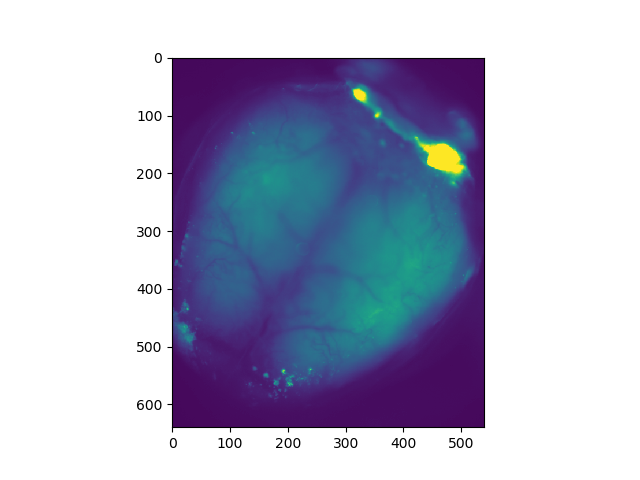

{'fig': <Figure size 640x480 with 1 Axes>,
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x29f4a07d308>,
 'im': <matplotlib.image.AxesImage at 0x29f4944c648>,
 'update': <function wfield.viz.nb_play_movie.<locals>.updateImage(change)>}

In [6]:
%matplotlib notebook
from wfield import *
frames = mmap_dat('d:data/DemoRec_new/Frames_2_640_540_uint16_0001.dat')
nb_play_movie(frames.reshape([-1,*frames.shape[-2:]])[ch1],clim=[0,65000])


In [70]:
frames.reshape([-1,*frames.shape[-2:]])

(416, 640, 540)